# Predictive Model and Analysis

In [1]:
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.svm import SVC
from scipy.stats import sem, t
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import plot_confusion_matrix, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# create two datasets with or without NaN hit value
music = pd.read_csv("wm_project.csv")

index_hit_isnan = music.isnull().any(axis=1)
music_w_nan = music[index_hit_isnan].reset_index().drop(['index'],axis=1)

music_value = music.dropna().drop(['id','track','uri'],axis=1)

In [3]:
# create feature set and label set for data with hit value
features = music_value.drop(['hit'],axis=1)
hit_label = music_value[['hit']]

- Based on my machine learning modeling experience, as we're going to run a multi-feature binary classfication, the tree models are the most suitable for this job. This experiment starts with Random Forest, as its ability of studying a lot of features is good.

In [4]:
def prediction_pipeline(features):
    update_columns = list(features.columns)
    
    X_train, X_test, y_train, y_test = train_test_split(features, hit_label, train_size = 0.7, random_state=0)
    
    clf_rf = RandomForestClassifier(n_estimators=500,n_jobs=-1,oob_score=True,
                                max_features='auto',random_state=0)
    clf_rf = clf_rf.fit(X_train,y_train)
    
    y_pred = clf_rf.predict(X_test)
    print(accuracy_score(y_pred,y_test))
    
    plot_confusion_matrix(clf_rf, X_test, y_test, values_format='d')
    
    print(sorted(dict(zip(update_columns,clf_rf.feature_importances_)).items(),key=lambda x:x[1],reverse=True))

- As mentioned in the EDA notebook, the artist feature is removed, and to make it suitable for model training, in the pre-processing step, the decade feature is encoded as number 0-5.

In [5]:
removed_features = ['artist']
features = features.drop(removed_features,axis=1)
le = LabelEncoder()
features['decade'] = le.fit_transform(features['decade'])

- The first experiement shows 79.78% accuracy, and the random forest model also picks the most important features, including **instrumentalness**, **acousticness**, and **danceability**. They are also among those features that have disparate distribution between hit and flop songs.

0.7978681012153815
[('instrumentalness', 0.17317419889156815), ('acousticness', 0.1120452299728682), ('danceability', 0.10065467220265611), ('energy', 0.07839660706146988), ('speechiness', 0.07360994097083462), ('loudness', 0.07097074938272917), ('duration_ms', 0.07056591632387976), ('valence', 0.06485107105131631), ('tempo', 0.05024100198070112), ('liveness', 0.047411966452658105), ('chorus_hit', 0.04675427720484277), ('decade', 0.03438251356224681), ('sections', 0.03413721879621328), ('key', 0.026351748916607153), ('mode', 0.00988119338904075), ('time_signature', 0.006571693840367777)]


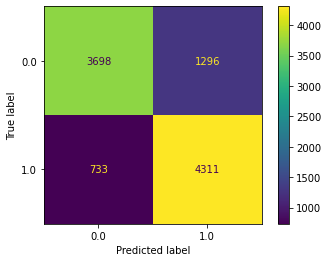

In [7]:
prediction_pipeline(features)

- As there are high correlation scores between the features **sections** and **duration_ms**, in the following experiment, I removed the 'section' feature to see how it performs.

In [8]:
removed_features = ['sections']
features = features.drop(removed_features,axis=1)

- The result shows the accuracy score is reduced a little, it shows that we can omit some highly dependent features, so that the computation resources can be saved without affecting the result too much.

0.797768479776848
[('instrumentalness', 0.16899865547139337), ('acousticness', 0.11054151851679452), ('danceability', 0.10210598240802209), ('energy', 0.0828361398397898), ('duration_ms', 0.07851589130899873), ('speechiness', 0.07600148608078353), ('loudness', 0.07542793403179457), ('valence', 0.06929774518384439), ('tempo', 0.053040239763786044), ('liveness', 0.051235942216078606), ('chorus_hit', 0.05019908560010054), ('decade', 0.034885056398717806), ('key', 0.028792171056837616), ('mode', 0.010379715628344183), ('time_signature', 0.007742436494714157)]


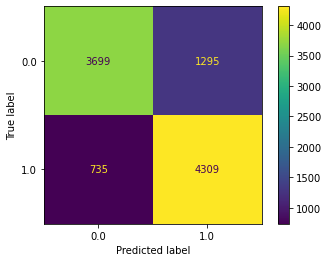

In [9]:
prediction_pipeline(features)

- In order to improve the accuracy, the next step is to change the method to transform 'decade' feature. As when it's encoded as number 0-5, the model may percept it to have larger/smaller relationship, it's better to have feature like 'decade_60s' and values as 0 or 1, so that this kind of miscorrelation can be avoided. 

In [10]:
features['decade']=music_value['decade']
features = pd.get_dummies(features,['decade'])

- The results show that this method improve the model performance, with 2% improvement. It shows this method does have effect on how the model can predict the results.

- Also, from the beginning to the end, the 3 most important features never change.

0.7997609085475195
[('instrumentalness', 0.16883752559710868), ('acousticness', 0.1111394223145086), ('danceability', 0.1000126739993407), ('energy', 0.08133284778994634), ('duration_ms', 0.07698842476553726), ('loudness', 0.07474498016277502), ('speechiness', 0.07469480526270711), ('valence', 0.06925524984333549), ('tempo', 0.052331652581769764), ('liveness', 0.05006075345152074), ('chorus_hit', 0.04892543249648113), ('key', 0.028278598825785917), ('decade_60s', 0.01092985951175982), ('mode', 0.01024932609519415), ('time_signature', 0.007933594050251623), ('decade_70s', 0.007557756129492342), ('decade_10s', 0.007421425620181976), ('decade_80s', 0.006889616769383461), ('decade_90s', 0.006857042241425431), ('decade_00s', 0.005559012491494395)]


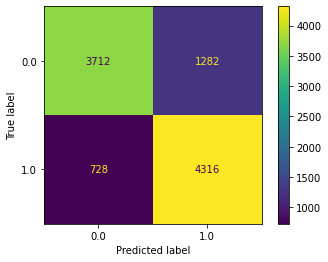

In [11]:
prediction_pipeline(features)

- Apart from Random Forest, another ensemble tree model is Extreme Gradient Boosting. So it's also implemented as the model for prediction. The result shows it can improve the accuray comparing with random forest. This is the best model we built in this experiment. 

[21:43:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8045427375971309


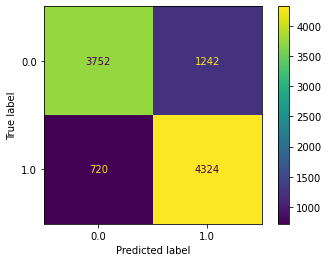

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, hit_label, train_size = 0.7, random_state=0)

clf_xgb = xgb.XGBClassifier(seed=0)
    
clf_xgb = clf_xgb.fit(X_train,y_train)

y_pred = clf_xgb.predict(X_test)
print(accuracy_score(y_pred,y_test))

plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d')

- From the visualization of the Extreme Gradient Boosting model, we can see that **danceabiliy**, **acousticness**, and **instrmentalness** play important roles in the decision-making process, which fits the observation from distribution plots. But it also misses **speechiness**, so it's also an imperfect method to locate the key features.

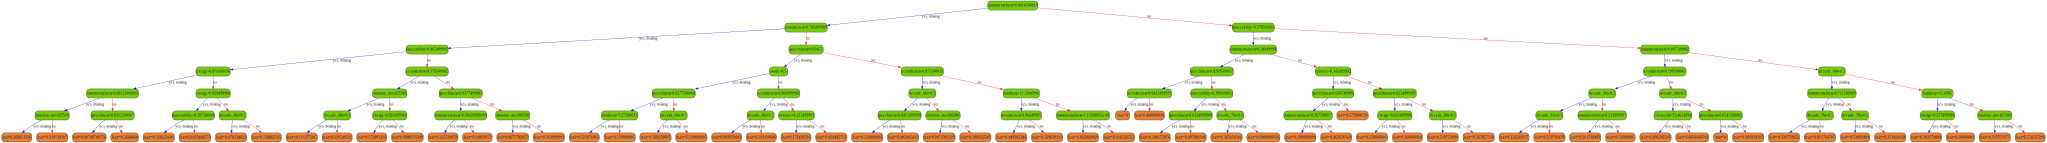

In [13]:
nodes_params={
    'shape':'box',
    'style':'filled,rounded',
    'fillcolor':'#78cbe'
}
leaf_params={
    'shape':'box',
    'style':'filled,rounded',
    'fillcolor':'#e48038'
}
xgb.to_graphviz(clf_xgb, num_trees=0, size="5,5",
                    condition_node_params=nodes_params,
                    leaf_node_params=leaf_params)

In [14]:
# Save the model as a pickle in a file
joblib.dump(clf_xgb, 'best_model.pkl')

['best_model.pkl']

# Feature analysis

- To explore how these features can be predictive for hit/flop songs, I also experimented with different sets of features based on my understanding of them. They are divided into **perceptual_features**, **content_features**, and **physical_features** of the songs.

In [15]:
perceptual_features = ['danceability', 'energy', 'valence']
content_features = ['speechiness', 'acousticness', 'instrumentalness', 'liveness']
physical_features = ['tempo','key','loudness','duration_ms','time_signature','chorus_hit','sections']

In [16]:
def learn_selected_dataset(features):
    selected_data = music_value[features]
    X_train, X_test, y_train, y_test = train_test_split(selected_data, hit_label, train_size = 0.7, random_state=0)
    
    clf_rf = RandomForestClassifier(n_estimators=500,n_jobs=-1,oob_score=True,
                                    max_features='auto',random_state=0)
    clf_rf = clf_rf.fit(X_train,y_train)
    
    y_pred = clf_rf.predict(X_test)
    print(accuracy_score(y_pred,y_test))
    plot_confusion_matrix(clf_rf, X_test, y_test, values_format='d')

- From the following results, we can see that content (like if it's a instrumental song, a live song, etc.) shows greatest importance in the analysis. And then it's the perceptual and physical features. So in order to decide if a song can be a hit, the content should be what people focus on at first. 

- However, even perceptual features are better for accuracy, they don't outcompete physical features in finding hit songs, the recall is smaller for them. So physical features can be a better choice to understand the hit songs.

0.6688583383144052


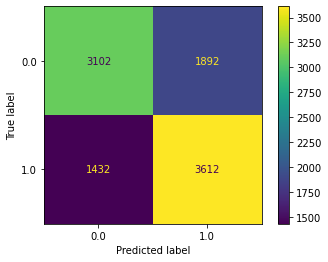

In [17]:
y_per = learn_selected_dataset(perceptual_features)

0.7305240087666866


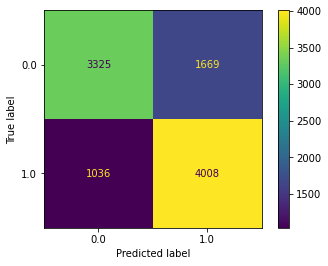

In [18]:
y_con = learn_selected_dataset(content_features)

0.6558079298665073


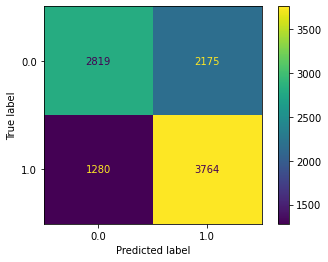

In [19]:
y_phy = learn_selected_dataset(physical_features)

# Expand dataset

- With the model trained, in order to do extensive analysis, I think it's a good way to use the model to make predictions, so that the data can be expanded and we can get a better understanding of the features that are related to hit songs.

In [20]:
music_w_nan = music_w_nan.drop(['id','track','uri'],axis=1)

In [21]:
music_w_nan = music_w_nan.drop(['artist','sections','hit'],axis=1)
music_w_nan = pd.get_dummies(music_w_nan,['decade'])

In [22]:
music_w_nan['hit'] = clf_xgb.predict(music_w_nan)
music_wo_nan = features
music_wo_nan['hit'] = music_value['hit']

In [23]:
complete_data = pd.concat([music_wo_nan,music_w_nan])
complete_data = complete_data.reset_index().drop(['index'],axis=1)

In [24]:
new_hit = complete_data[complete_data['hit']==1]
new_flop = complete_data[complete_data['hit']==0]

- With the new dataset, we can compute the confidence intervals as another method to demonstrate the difference between songs from the two groups.

In [25]:
def conf_int(scores):

    confidence = 0.95
    data = scores

    n = len(data)
    m = np.mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)

    start = m - h
    end = m + h

    return([start,end])

- Based on the new dataset, we can see from the following results that **danceability**, **loudness**, **acousticness**, **valence**, and especially **instrumentalness** are really different between two groups (differ by over 10%). 

In [26]:
for feature in complete_data.columns[:-7]:
    print("{}:".format(feature))
    ci_hit = conf_int(new_hit[feature])
    print("CI for hits:",ci_hit)
    ci_flop = conf_int(new_flop[feature])
    print("CI for flops:",ci_flop)

danceability:
CI for hits: [0.6001969570747476, 0.6042846326835378]
CI for flops: [0.4721774020827451, 0.4771742218146056]
energy:
CI for hits: [0.6215417834401012, 0.6268897442182523]
CI for flops: [0.5285173860110343, 0.5366208363225643]
key:
CI for hits: [5.2018426752449045, 5.298300632293072]
CI for flops: [5.120771864156784, 5.218141527984355]
loudness:
CI for hits: [-8.731731735783095, -8.634467079541112]
CI for flops: [-11.907852545229957, -11.73439875789757]
mode:
CI for hits: [0.7259183907753968, 0.7379203404752004]
CI for flops: [0.6471165226843567, 0.6603213281576641]
speechiness:
CI for hits: [0.06813079476203367, 0.07019891766750623]
CI for flops: [0.07544491314004914, 0.07808013698024055]
acousticness:
CI for hits: [0.2749917827903197, 0.28236029647117106]
CI for flops: [0.4490128253027943, 0.459457515118218]
instrumentalness:
CI for hits: [0.025848054045001803, 0.029147395556603624]
CI for flops: [0.2804960761793918, 0.29081310046154735]
liveness:
CI for hits: [0.1890881

# Summary

- Based on the observation from different perspectives, we can see that **acousticness**, **instrumentalness**, and **danceability** are the most agreed features that decide whether a song can be a hit. From my understanding, I think **acousticness**, **instrumentalness** are more contributive in filtering out those songs that can't be a hit, as the related genres are generally less popular. But for **danceability**, it can represent a hit song's feature, since a song people can dance to will have more chances to be played to a lot of audience, which promotes its chance to be a hit.

- The best predictive model is Extreme Gradient Boosting. As the tree models learn by partitioning the data, it doesn't require scaling. As this data have other informative features that are not fully utilized, a neural network model can have the potential to improve the performance of prediciton.